In [1]:
%%time
import sys, os
# import pickle
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/CerebellarLoop'
path_data = f'/mnt/User_Data/UserData/eliasmfs/CerebellarLoop/SlowData/'
path_code = f'{path_gen}/Code/{year}/CerebellarLoop'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
import collections
import scipy.signal
import tqdm
import functools
from IPython.display import HTML, display
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')



record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 100
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['negative','positive']

           
seed_number_range = []     
for num in [4.2]:
    seed_number_range.append(f'eyeblink_int_{num}')                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 1
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')


f0_range = ["eye_blink"]

parameters_value = { "range_plasticity": range_plasticity, "range_after_plasticity": range_after_plasticity,
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02
                    "unfiltered": False, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "simulations": sims,
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}


Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = f0_range[0]

@functools.lru_cache
def load_plasticity(coupling=True, plasticity=True, zebrin=True, n=0, f0=0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    return output_load_run('mon_N_PC','_Coupled' if coupling else '',seed_number,
                           p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)['new_weight']

@functools.lru_cache
def load_io_vs(coupling=True, plasticity=True, zebrin=True, n=0, f0=0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    IO_output = output_load_run('IO',
                                '_Coupled' if coupling else '',seed_number,
                                p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)
    return np.array(IO_output['Vs']/mV)


class Case(collections.abc.Mapping):
    def __init__(self, **kw):
        self.kw = kw
        for k in kw:
            assert k in ['coupling', 'zebrin', 'plasticity']
    def __len__(self):
        return 1
    def __getitem__(self, k):
        return self.kw[k]
    def __iter__(self):
        return iter(self.kw)
    def __eq__(self, other):
        for k in ['coupling', 'zebrin', 'plasticity']:
            if self.kw.get(k, '*') !=  other.kw.get(k, '*'):
                return False
        return True
    def __hash__(self):
        return __builtins__.sum(hash(f'{k}{self.kw.get(k, "*")}') for k in ['coupling', 'zebrin', 'plasticity'])
    @property
    def before(self):
        kw = dict(self.kw)
        kw['plasticity'] = False
        return Case(**kw)
    @property
    def after(self):
        kw = dict(self.kw)
        kw['plasticity'] = True
        return Case(**kw)
    @property
    def during(self):
        kw = dict(self.kw)
        kw['plasticity'] = None
        return Case(**kw)
    def __repr__(self):
        return '/'.join([
            {True: 'C', False: 'U', '*': '*'}[self.kw.get('coupling', '*')],
            {True: 'Z+', False: 'Z-', '*': '*'}[self.kw.get('zebrin', '*')],
            {True: 'AP', False: 'NP', None: 'P', '*': '*'}[self.kw.get('plasticity', '*')]])
        

CP = Case(coupling=True, zebrin=True)
CN = Case(coupling=True, zebrin=False)
UP = Case(coupling=False, zebrin=True)
UN = Case(coupling=False, zebrin=False)

WARNING    <timed exec>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
 [py.warnings]



CPU times: user 29.3 s, sys: 10.2 s, total: 39.6 s
Wall time: 54.5 s


# Figure S6 - A

CPU times: user 1.88 s, sys: 11.6 s, total: 13.5 s
Wall time: 2min 20s


Text(0.5, 1.0, 'Weight shift NP/AP CS/US trials')

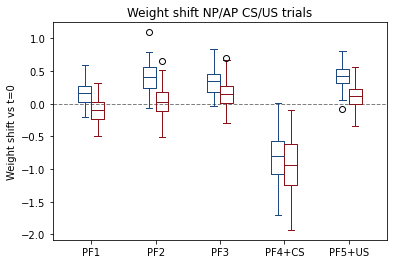

In [2]:
%%time
#f = load_plasticity(**CN.during, n=1, f0=0, noise_gain=1).reshape((100, 5, 2*60000))

f1 = load_plasticity(**CP.during, n=1, f0='eye_blink', noise_gain=1).reshape((100, 5, 2*60000))
f2 = load_plasticity(**CN.during, n=1, f0='eye_blink', noise_gain=1).reshape((100, 5, 2*60000))
f1a = load_plasticity(**CP.after, n=1, f0='eye_blink', noise_gain=1).reshape((100, 5, 2*60000))
f2a = load_plasticity(**CN.after, n=1, f0='eye_blink', noise_gain=1).reshape((100, 5, 2*60000))

d1 = f1a[:,:,0] - f1[:,:,0]
d2 = f2a[:,:,0] - f2[:,:,0]

X = 1+np.arange(5)


bp = plt.boxplot(d1, positions=X-.1, widths=.2);
for v in bp.values():
    for l in v:
        l.set_color('#1c4981')
bp = plt.boxplot(d2, positions=X+.1, widths=.2);
for v in bp.values():
    for l in v:
        l.set_color('#8a1218')
def extra(i):
    if i == 4:
        return '+CS'
    if i == 5:
        return '+US'
    return ''
plt.xticks(X, [f'PF{x}'+extra(x) for x in range(1, 6)])
plt.ylabel('Weight shift vs t=0')
A = 1.1
#plt.ylim([-A, A])
plt.axhline(0, zorder=-1, lw=1, ls='--', color='gray')
plt.title('Weight shift NP/AP CS/US trials')
# plt.savefig('svg/weightshiftuscs.svg')

# Figure S6 - B

CPU times: user 29.3 ms, sys: 1.08 ms, total: 30.4 ms
Wall time: 27.5 ms


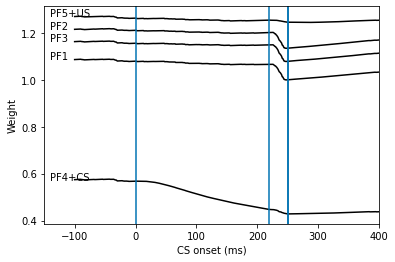

In [3]:
%%time
Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
iti_arr = Noise_sim['iti_arr_eye_blink']
# iti_arr = [10*second]*len(iti_arr)
iti_arr = iti_arr*second
iti_arr

CS_dur = 220*ms
US_dur = 30*ms
transient = iti_arr[0]
ini_US_onset = transient
ini_US_ofset = transient+US_dur
CS_onset = [ini_US_ofset+iti_arr[1]]
US_onset = [CS_onset[0]+CS_dur]
CS_ofset = [CS_onset[0]+CS_dur+US_dur]
US_ofset = [US_onset[0]+US_dur]

for idx,iti in enumerate(iti_arr[2:-1]):
    CS_onset.append(CS_ofset[idx]+iti)
    US_onset.append(US_ofset[idx]+iti+CS_dur)
    CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
    US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)

CS_onset = np.array(CS_onset)
US_onset = np.array(US_onset)
CS_ofset = np.array(CS_ofset)
US_ofset = np.array(US_ofset)

dcn_to_io = [[] for _ in range(40)]
src = Synaps['Seed_'+str(seed_number)].DCN_IO_Synapse_Sources
tgt = Synaps['Seed_'+str(seed_number)].DCN_IO_Synapse_Targets
for a, b in zip(src, tgt):
    dcn_to_io[a].append(b)
dcn_to_io = [np.array(x) for x in dcn_to_io]

f1 = load_plasticity(**CP.during, n=1, f0='eye_blink', noise_gain=1).reshape((100, 5, 2*60000))

idxs = (CS_onset*1e3).astype(int)
start = 100

T = np.arange(-start, 400)

def extra(i):
    if i == 4:
        return '+CS'
    if i == 5:
        return '+US'
    return ''
for pf in range(5):

    w = []
    for i, idx in enumerate(idxs):
        x = f1[:,:,idx-start:idx+400]
        w.extend(x[:, pf])
    mu = np.mean(w, axis=0)
    #low = np.percentile(w, 40, axis=0)
    #high = np.percentile(w, 60, axis=0)
    #plt.fill_between(np.arange(len(mu)), low, high, color='black', alpha=0.5)
    plt.plot(T, mu, color='black')#, alpha=(.5 + .5*i/len(idxs)))
    plt.text(-140, mu[0], f'PF{pf+1}{extra(pf+1)}')
    
i = 0
idx = idxs[0]
plt.axvline(0)
plt.axvline((CS_ofset[i]*1e3-idx))
plt.axvline((US_onset[i]*1e3-idx))
plt.axvline((US_ofset[i]*1e3-idx))
plt.xlim(-150, 400)
plt.xlabel('CS onset (ms)')
plt.ylabel('Weight')
# plt.savefig('svg/weightovertimeuscs.svg')
None

# Figure S6 - C

CPU times: user 1.71 s, sys: 1.34 s, total: 3.05 s
Wall time: 11.3 s


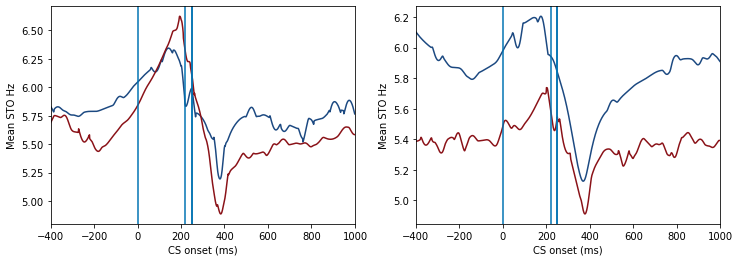

In [4]:
%%time
from scipy.signal import savgol_filter
fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(12, 4))

def calc_phase(vs, fs=1000, order=5, lp=4, hp=15):
    'Ncells x Ntimesteps -> Ntimesteps'
    # synchrony changing faster than 5Hz doens't make sense for 10Hz STO's
    sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    angle = np.angle(analytic)
    return angle
for iii, cases in enumerate([[CP.before, CN.before], [CP.after, CN.after]]):
    for clr, case in zip(['#1c4981', '#8a1218'], cases):
        v = np.array(load_io_vs(**case, n=1, f0='eye_blink', noise_gain=1))
        phase = np.unwrap(calc_phase(v, lp=4, hp=8))
        phase = savgol_filter(phase, 51, 3)
        d = np.diff(phase)
        d = d.mean(0) / np.pi / 2 * 1000
        #plt.plot(d)

        #d = calc_synchrony()


        idxs = (CS_onset*1e3).astype(int)
        start = 400
        end = 1000

        T = np.arange(-start, end)


        w = []
        for i, idx in enumerate(idxs):
            x = d[idx-start:idx+end]
            w.append(x)
        mu = np.mean(w, axis=0)
        #low = np.percentile(w, 40, axis=0)
        #high = np.percentile(w, 60, axis=0)
        #plt.fill_between(np.arange(len(mu)), low, high, color='black', alpha=0.5)
        ax[iii].plot(T, mu, color=clr)#, alpha=(.5 + .5*i/len(idxs)))

    i = 0
    idx = idxs[0]
    ax[iii].axvline(0)
    ax[iii].axvline((CS_ofset[i]*1e3-idx))
    ax[iii].axvline((US_onset[i]*1e3-idx))
    ax[iii].axvline((US_ofset[i]*1e3-idx))
    ax[iii].set_xlim(-start, end)
    ax[iii].set_xlabel('CS onset (ms)')
    #plt.ylabel('Weight')
    None

    # d = np.cumsum(d)
    # print(d.shape)
    # d = savgol_filter(d, 1001, 3)
    # d = d[20000:100000]
    # d = d - d[0]
    # #d = d - np.linspace(0, 80*2*np.pi*5.5, len(d))
    # D = d[-1] - d[0]
    # d = d - np.linspace(d[0], d[-1], len(d))
    # d = d / (100-20)
    # plt.plot(d, label=repr(case))
    # # plt.plot(np.diff(d[100:-100])*1000/2/np.pi)
    #plt.ylim([4, 8])
    ax[iii].set_ylabel('Mean STO Hz')
    
# plt.savefig('svg/stodiffuscs.svg')